# Global Parameter Transfer

Can we use the parameter values from the subsampled data to inform a model at a much more frequent timestep?
This would allow us to save some time during the macro parameter optimization.

It seems like the answer is no.
- We can't use the same parameters from the coarser time steps
- We can't use linear regression to find the "optimal" parameters at the model time step. It's not nearly as good
  as the optimized result.
  
My guess for the latter point is that the model is being run at a finer timestep than the governing dynamics.
So there is probably an "optimal" timestep, where the model is being run at the maximum dynamically stable timestep,
and this is the last point that any kind of trend would follow.
But, since we are at a higher frequency, the ESN is basically balancing the frequency of the dynamics with
the frequency of the input data ... This is pretty hand-wavy and would need to be tested...

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns

from ddc import YAMLParser

In [2]:
sys.path.append("..")
from rcgfd import RCDataset, SingleTimePlot, plot_ke_relerr, MetricsPlot

In [3]:
plt.style.use("./rc-gfd.mplstyle")

In [4]:
yp = YAMLParser()
config = lambda delta_t : yp.read(
    f"/contrib/Tim.Smith/qgrc-teachers/sqg/resolution/rc-temporal-sampling-064n/cost-nrmse1.0e+00-spectral1.0e-01/macro-calibration-{delta_t:04d}dt/config-optim.yaml"
)

In [5]:
dt0 = 300
n_subs = [1, 4, 16, 48]
rc = {
    n_sub: config(dt0*n_sub)["rc"] for n_sub in n_subs
}

In [6]:
parameters = ["sigma", "spectral_radius", "sigma_bias", "leak_rate", "tikhonov_parameter"]

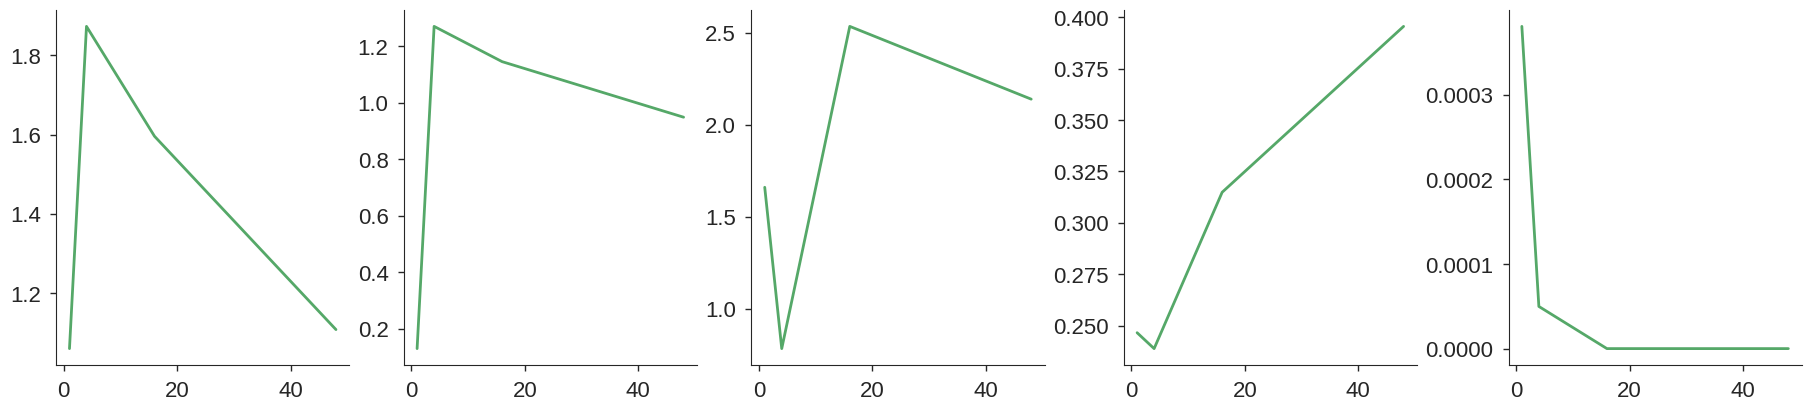

In [7]:
fig, axs = plt.subplots(1,5, figsize=(18,4), constrained_layout=True, sharex=True)

for parameter, ax in zip(parameters, axs):
    ax.plot(n_subs, [rc[n_sub][parameter] for n_sub in n_subs])

## What would the parameters be, taking linear regression?

In [8]:
from copy import deepcopy

In [31]:
linear = deepcopy(rc)
deg = 1
for parameter in parameters:
    x = n_subs[1:]
    y = [rc[ns][parameter] for ns in n_subs[1:]]
    f = np.polyfit(x=x, y=y, deg=deg)
    new_p = np.polyval(p=f, x=deg)
    linear[1][parameter] = new_p

In [32]:
semilinear = deepcopy(rc)
for parameter in parameters:
    x = n_subs[1:]
    y = [rc[ns][parameter] for ns in n_subs[1:]]
    if "tikh" in parameter or "leak" in parameter:
        deg = 2
        y = np.log10(y)
    else:
        deg = 1
    f = np.polyfit(x=x, y=y, deg=deg)
    new_p = np.polyval(p=f, x=deg)
    if "tikh" in parameter or "leak" in parameter:
        new_p = 10.**new_p
    semilinear[1][parameter] = new_p


In [33]:
deg = 1
last2 = deepcopy(rc)
for parameter in parameters:
    x = n_subs[1:-1]
    y = [rc[ns][parameter] for ns in n_subs[1:-1]]
    if "tikh" in parameter:
        y = np.log10(y)
    f = np.polyfit(x=x, y=y, deg=deg)
    new_p = np.polyval(p=f, x=deg)
    if "tikh" in parameter:
        new_p = 10.**new_p
    last2[1][parameter] = new_p

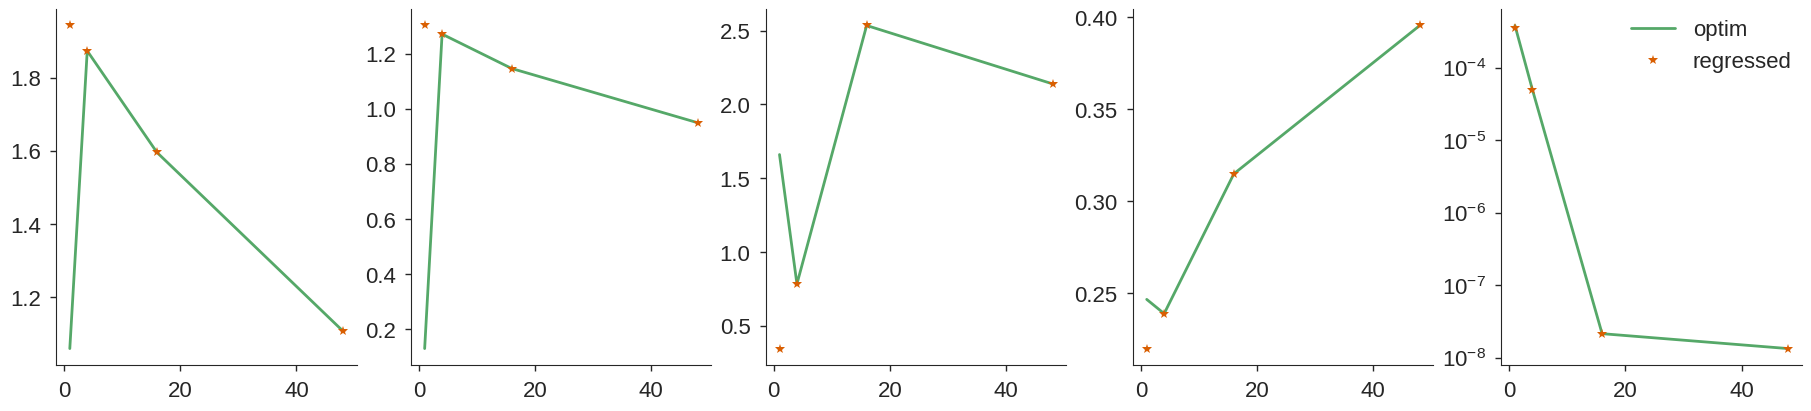

In [35]:
fig, axs = plt.subplots(1,5, figsize=(18,4), constrained_layout=True, sharex=True)

for parameter, ax in zip(parameters, axs):
    ax.plot(n_subs, [rc[n_sub][parameter] for n_sub in n_subs])
    #ax.plot(n_subs, [linear[n_sub][parameter] for n_sub in n_subs], '*', ls='')
    #ax.plot(n_subs, [semilinear[n_sub][parameter] for n_sub in n_subs], '*', ls='')
    ax.plot(n_subs, [last2[n_sub][parameter] for n_sub in n_subs], '*', ls='')
    
axs[-1].set(yscale="log")
fig.legend(("optim", "regressed"))

In [13]:
parameters

['sigma', 'spectral_radius', 'sigma_bias', 'leak_rate', 'tikhonov_parameter']

In [14]:
for p in parameters:
    print(f"{p}: {linear[1][p]:.4e}")

sigma: 1.8930e+00
spectral_radius: 1.2748e+00
sigma_bias: 1.3442e+00
leak_rate: 2.4386e-01
tikhonov_parameter: 3.6117e-05


In [15]:
for p in parameters:
    print(f"{p}: {semilinear[1][p]:.4e}")

sigma: 1.8930e+00
spectral_radius: 1.2748e+00
sigma_bias: 1.3442e+00
leak_rate: 2.2574e-01
tikhonov_parameter: 2.7115e-04


In [16]:
for p in parameters:
    print(f"{p}: {last2[1][p]:.4e}")

sigma: 1.9427e+00
spectral_radius: 1.3017e+00
sigma_bias: 3.4549e-01
leak_rate: 2.1977e-01
tikhonov_parameter: 3.4617e-04


## Do the parameters transfer from subset data to model timestep data?

In [17]:
class RCTransferDataset(RCDataset):
    delta_t0 = 300
    
    def get_results_path(self, cost, n_sub):
        
        main_dir = "cost-"
        main_dir += "-".join(f"{k}{v:1.1e}" for k,v in cost.items())
        
        dt0 = 300
        delta_t_in = n_sub * dt0
        out_dir = f"/contrib/Tim.Smith/qgrc-teachers/sqg/resolution/rc-temporal-sampling-064n/{main_dir}/"
        if n_sub > 1:
            out_dir += f"transfer-validation-{delta_t_in:04d}dt-{self.delta_t0:04d}dt-{self.n_samples:03d}samples/"
        else:
            out_dir += f"validation-{self.delta_t0:04d}dt-{self.n_samples:03d}samples/"
        fname = out_dir + "results.zarr"
        
        return main_dir, fname

In [18]:
rctd = RCTransferDataset(
    n_sub=(1,4,16),
    cost_terms={"nrmse": 1, "spectral": 0.1},
)

In [19]:
ds = rctd()

In [20]:
stp = SingleTimePlot(diff_t0=False, time=4*3600)

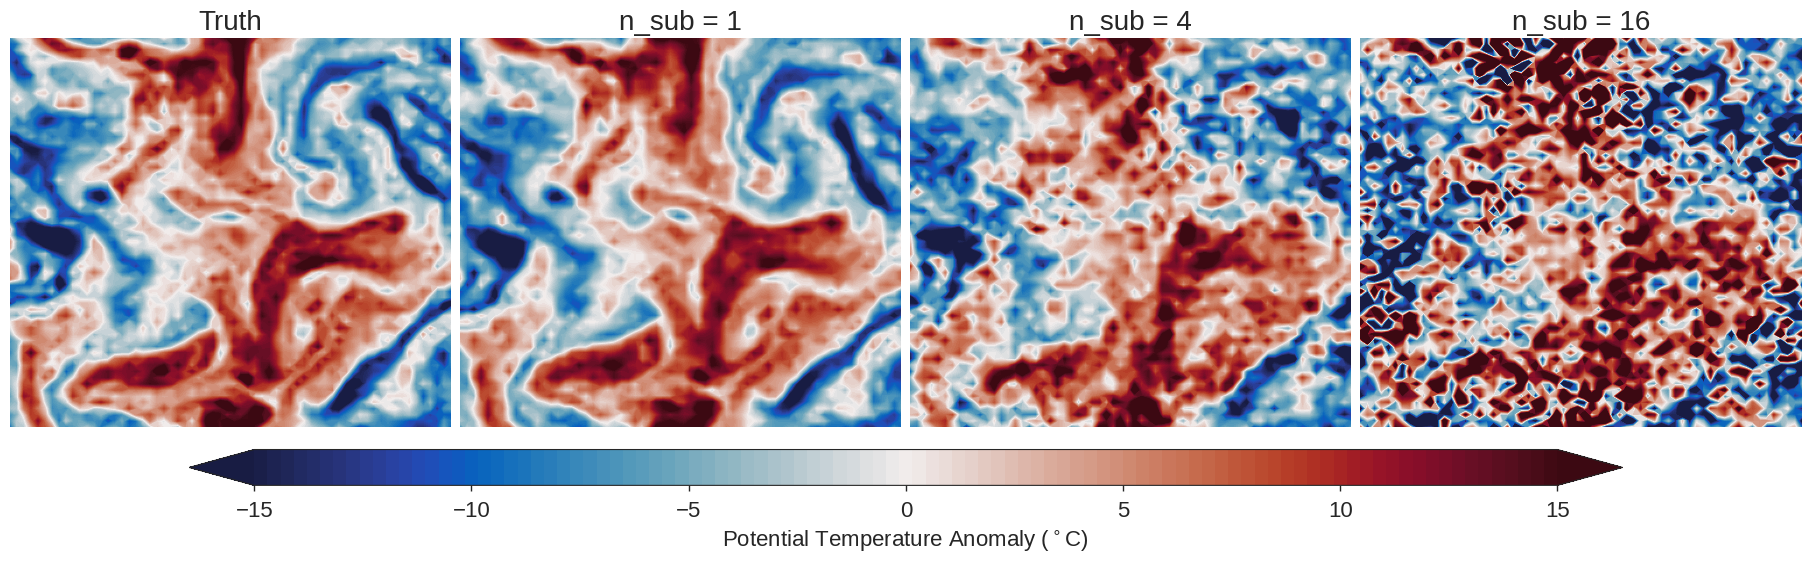

In [21]:
fig, axs = stp(ds.sel(sample=49), col_dim="n_sub")

## Can we use the regression result?

In [22]:
class RCLinearDataset(RCDataset):
    delta_t0 = 300
    regression = None
    
    def get_results_path(self, cost, n_sub):
        
        main_dir = "cost-"
        main_dir += "-".join(f"{k}{v:1.1e}" for k,v in cost.items())
        
        dt0 = 300
        delta_t_in = n_sub * dt0
        out_dir = f"/contrib/Tim.Smith/qgrc-teachers/sqg/resolution/rc-temporal-sampling-064n/{main_dir}/"
        if regression is not None:
            out_dir += f"{self.regression}-validation-{self.delta_t0:04d}dt-{self.n_samples:03d}samples/"
        else:
            out_dir += f"validation-{self.delta_t0:04d}dt-{self.n_samples:03d}samples/"
        fname = out_dir + "results.zarr"
        
        return main_dir, fname

In [23]:
dslist = []
for regression in [None, "linear", "semilinear"]:
    rcld = RCLinearDataset(
        n_sub=(1),
        cost_terms={"nrmse": 1, "spectral": 0.1},
        regression=regression,
    )
    rstr = regression if regression is not None else "optim"
    dslist.append(rcld().expand_dims({"regression": [rstr]}))
ds = xr.concat(dslist, dim="regression")

In [24]:
ds["truth"] = ds.truth.isel(regression=0)

In [27]:
stp = SingleTimePlot(diff_t0=False, time=8*3600)

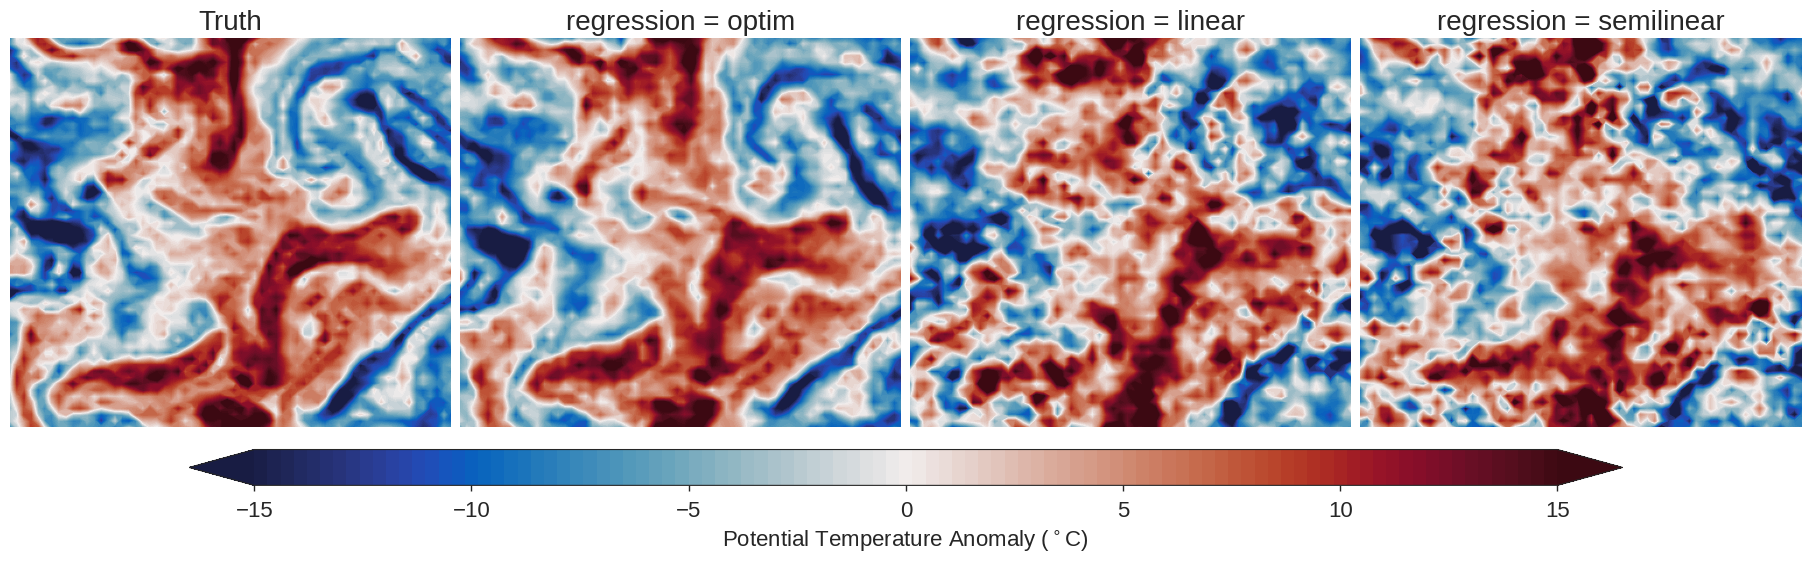

In [28]:
fig, axs = stp(ds.sel(sample=49), col_dim="regression")

In [26]:
ds.nrmse.load();

In [29]:
mp = MetricsPlot(
    metrics=("nrmse", "ke_nrmse"),
    cdim="regression",
    cdim_label=lambda r: r
)

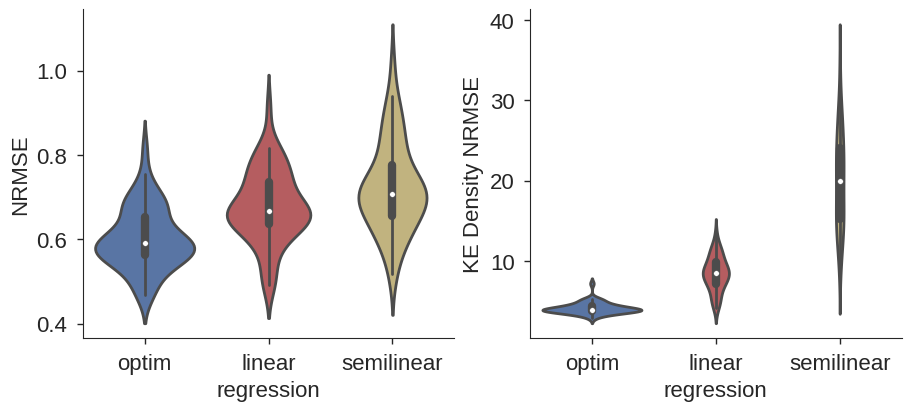

In [30]:
fig, axs = mp(ds, show_time=False)